In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
%matplotlib inline

Read in the data

In [2]:
data = pd.read_csv("FRB_H15.csv",header = 0,skiprows = 5).replace('ND',np.nan)
data.drop(['RIFLGFCM01_N.B','RIFLGFCM03_N.B','RIFLGFCM06_N.B','RIFLGFCY02_N.B','RIFLGFCY07_N.B','RIFLGFCY20_N.B','RIFLGFCY30_N.B'],axis = 1,inplace = True)
data['Time Period'] = pd.to_datetime(data['Time Period'])

In [3]:
data

,Time Period,RIFLGFCY01_N.B,RIFLGFCY03_N.B,RIFLGFCY05_N.B,RIFLGFCY10_N.B
0,1962-01-02,3.22,3.70,3.88,4.06
1,1962-01-03,3.24,3.70,3.87,4.03
2,1962-01-04,3.24,3.69,3.86,3.99
3,1962-01-05,3.26,3.71,3.89,4.02
4,1962-01-08,3.31,3.71,3.91,4.03
5,1962-01-09,3.32,3.74,3.93,4.05
6,1962-01-10,3.33,3.75,3.94,4.07
7,1962-01-11,3.33,3.77,3.94,4.08
8,1962-01-12,3.30,3.76,3.95,4.08
9,1962-01-15,3.32,3.79,3.96,4.10


Generate dates, as there are missing dates in data

In [4]:
dates = pd.DataFrame(pd.date_range(start = '1962-01-02',end = '2017-10-5'))
dates.columns = ['Time Period']

Left join the generated dates, and the dates from the data. The dates which are missing in the data will have NA values this way.

In [5]:
data = dates.merge(data,how = 'left',on = 'Time Period')

Create weekend and day of week features

In [6]:
data['IS_WEEKEND'] = 1
data['Day of week'] = data['Time Period'].dt.dayofweek
weekend = data['IS_WEEKEND'].copy()
weekend[(data['Day of week'] != 5) & (data['Day of week'] != 6)] = 0
data['IS_WEEKEND'] = weekend

Impute missing values in the table. Use most recent existing values for imputation.

In [7]:
f1 = data['RIFLGFCY01_N.B'].copy()
f2 = data['RIFLGFCY03_N.B'].copy()
f3 = data['RIFLGFCY05_N.B'].copy()
f4 = data['RIFLGFCY10_N.B'].copy()
for i in range(len(data)):
    if data['IS_WEEKEND'].iloc[i] == 1:
        f1[i] = f1[i-1]
        f2[i] = f2[i-1]
        f3[i] = f3[i-1]
        f4[i] = f4[i-1]
        
for i in range(len(f1)):
    if pd.isnull(f1[i]):
        j = i - 1
        while pd.isnull(f1[j]):
            j = j - 1
        f1[i] = f1[j]

for i in range(len(f2)):
    if pd.isnull(f2[i]):
        j = i - 1
        while pd.isnull(f2[j]):
            j = j - 1
        f2[i] = f2[j]

for i in range(len(f3)):
    if pd.isnull(f3[i]):
        j = i - 1
        while pd.isnull(f3[j]):
            j = j - 1
        f3[i] = f3[j]

for i in range(len(f4)):
    if pd.isnull(f4[i]):
        j = i - 1
        while pd.isnull(f4[j]):
            j = j - 1
        f4[i] = f4[j]
        
data['RIFLGFCY01_N.B'] = f1
data['RIFLGFCY03_N.B'] = f2
data['RIFLGFCY05_N.B'] = f3
data['RIFLGFCY10_N.B'] = f4

In [8]:
data.to_csv("Weekend Imputed.csv",index = False)

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.tools.plotting import autocorrelation_plot

In [10]:
data['RIFLGFCY01_N.B'] = data['RIFLGFCY01_N.B'].astype(float)
data['RIFLGFCY03_N.B'] = data['RIFLGFCY03_N.B'].astype(float)
data['RIFLGFCY05_N.B'] = data['RIFLGFCY05_N.B'].astype(float)
data['RIFLGFCY10_N.B'] = data['RIFLGFCY10_N.B'].astype(float)

Generate autocorrelation plot for 2010-2017 data

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


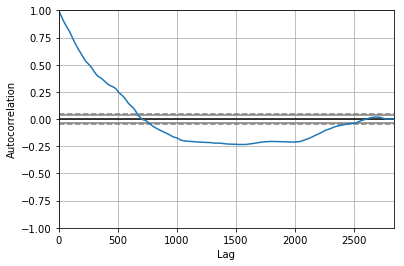

In [11]:
autocorrelation_plot(data['RIFLGFCY01_N.B'][17531:])
plt.show()

In [12]:
autocorrlist = []
for i in range(100):
    autocorrlist.append(data['RIFLGFCY01_N.B'][17531:].autocorr(lag = i))

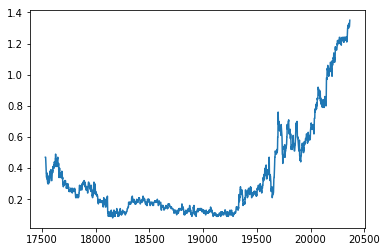

In [13]:
plt.plot((data['RIFLGFCY01_N.B'][17531:]))
plt.show()

In [14]:
data[17531:17532]

,Time Period,RIFLGFCY01_N.B,RIFLGFCY03_N.B,RIFLGFCY05_N.B,RIFLGFCY10_N.B,IS_WEEKEND,Day of week
17531,2010-01-01,0.47,1.7,2.69,3.85,0,4


In [15]:
data.to_csv("Imputed Data.csv",index = False)

Compute rolling mean for a window of 100 days

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  


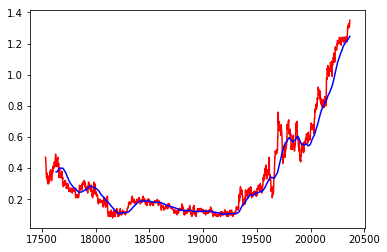

In [16]:
plt.plot(data['RIFLGFCY01_N.B'][17531:],color = 'red')
plt.plot(pd.rolling_mean((data['RIFLGFCY01_N.B'][17531:]),100),color = 'blue')
plt.show()

Difference the data from the rolling mean to detrend it

In [17]:
diff = (data['RIFLGFCY01_N.B'][17531:] - pd.rolling_mean((data['RIFLGFCY01_N.B'][17531:]),100))

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  """Entry point for launching an IPython kernel.


Check for stationarity using dickey fuller test

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


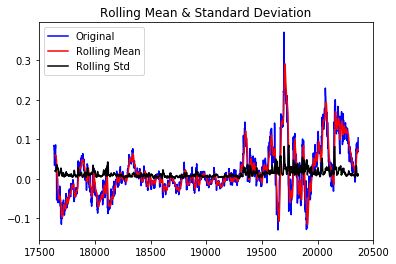

Results of Dickey-Fuller Test:
Test Statistic                   -5.593215
p-value                           0.000001
#Lags Used                       28.000000
Number of Observations Used    2707.000000
Critical Value (5%)              -2.862608
Critical Value (1%)              -3.432768
Critical Value (10%)             -2.567339
dtype: float64


In [19]:
test_stationarity(diff[99:])

In [20]:
data_after_2000 = data[data['Time Period']>='2000-01-01'].set_index('Time Period')

In [21]:
data_after_2000

,RIFLGFCY01_N.B,RIFLGFCY03_N.B,RIFLGFCY05_N.B,RIFLGFCY10_N.B,IS_WEEKEND,Day of week
Time Period,,,,,,
2000-01-01,5.98,6.29,6.36,6.45,1,5
2000-01-02,5.98,6.29,6.36,6.45,1,6
2000-01-03,6.09,6.42,6.50,6.58,0,0
2000-01-04,6.00,6.34,6.40,6.49,0,1
2000-01-05,6.05,6.43,6.51,6.62,0,2
2000-01-06,6.03,6.39,6.46,6.57,0,3
2000-01-07,6.00,6.35,6.42,6.52,0,4
2000-01-08,6.00,6.35,6.42,6.52,1,5
2000-01-09,6.00,6.35,6.42,6.52,1,6


In [22]:
#remove weekend
data_after_2000 = data_after_2000[data_after_2000['IS_WEEKEND']==0]

#difference data from rolling mean
data_after_2000_diff = (data_after_2000 - pd.rolling_mean((data_after_2000),100))



#train on 2000-2016, test on 2017
train = data_after_2000_diff[data_after_2000_diff.index<='2016-12-31'].iloc[100:,]
test = data_after_2000_diff[data_after_2000_diff.index>='2017-01-01']

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  """


In [23]:
#Try one year maturity
train_one_year = train['RIFLGFCY01_N.B']
test_one_year = test['RIFLGFCY01_N.B']


D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


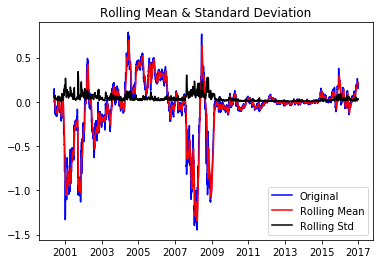

Results of Dickey-Fuller Test:
Test Statistic                   -4.742892
p-value                           0.000070
#Lags Used                       21.000000
Number of Observations Used    4313.000000
Critical Value (5%)              -2.862210
Critical Value (1%)              -3.431867
Critical Value (10%)             -2.567127
dtype: float64


In [24]:
test_stationarity(train_one_year)

In [27]:
arma_order_select_ic(train_one_year,ic=['aic', 'bic'])

{'aic':               0             1             2
 0   2515.942250  -2809.305896  -6507.595351
 1 -15636.913765 -15642.339566 -15645.097039
 2 -15641.817149 -15642.857995 -15643.443031
 3 -15645.486157 -15643.620297 -15656.629162
 4 -15643.715765 -15642.119628 -15655.948749,
 'aic_min_order': (3, 2),
 'bic':               0             1             2
 0   2528.691204  -2790.182466  -6482.097443
 1 -15617.790335 -15616.841658 -15613.224655
 2 -15616.319241 -15610.985611 -15605.196170
 3 -15613.613773 -15605.373436 -15612.007824
 4 -15605.468903 -15597.498290 -15604.952934,
 'bic_min_order': (1, 0)}

In [41]:

predictions = []
train_temp = list(train_one_year)
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_one_year)):
    model = ARIMA(train_temp, order=(3,1,2))
    model_fit = model.fit(trend = 'nc')
    pred = model_fit.forecast()[0]
    predictions.append(float(pred))
    obs = test_one_year[t]
    train_temp.append(obs)
    print('predicted= ',pred[0], 'expected= ',obs)

error = mean_squared_error(list(test_one_year), predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: ' , error)

#predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=  0.152946524965 expected=  0.1482
predicted=  0.148740834116 expected=  0.185
predicted=  0.184391436096 expected=  0.1621
predicted=  0.161843568565 expected=  0.1196
predicted=  0.117895212555 expected=  0.137
predicted=  0.139477086737 expected=  0.1046
predicted=  0.102980027413 expected=  0.1022
predicted=  0.101124167489 expected=  0.0999
predicted=  0.102673245493 expected=  0.0878
predicted=  0.0853643668546 expected=  0.0958
predicted=  0.0962397063285 expected=  0.0938
predicted=  0.0955272714424 expected=  0.0719
predicted=  0.0687700311258 expected=  0.0898
predicted=  0.0920792390487 expected=  0.0975
predicted=  0.0985344198314 expected=  0.0852
predicted=  0.0816258181493 expected=  0.0532


D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  

predicted=  0.0545223576694 expected=  0.0707
predicted=  0.0727685425689 expected=  0.0782
predicted=  0.0759353841864 expected=  0.0757
predicted=  0.0760699408833 expected=  0.0733
predicted=  0.0745456486538 expected=  0.0609
predicted=  0.0588393537419 expected=  0.0888
predicted=  0.0908839197446 expected=  0.0767
predicted=  0.0762640856737 expected=  0.0843
predicted=  0.0828066123241 expected=  0.0622
predicted=  0.0634861822979 expected=  0.0303
predicted=  0.0286001250547 expected=  0.0384
predicted=  0.0393705163948 expected=  0.0266
predicted=  0.0270778592419 expected=  0.0346
predicted=  0.0333810285782 expected=  0.0425
predicted=  0.0439237242228 expected=  0.0501
predicted=  0.0499069129308 expected=  0.0675
predicted=  0.0671859358723 expected=  0.0849
predicted=  0.0861487056789 expected=  0.0426
predicted=  0.0398716437937 expected=  0.0403
predicted=  0.0412737850995 expected=  0.0384
predicted=  0.0401350855789 expected=  0.0465
predicted=  0.044252825982 expecte

predicted=  0.103805973465 expected=  0.1208


Printing Mean Squared Error of Predictions...
Test MSE:  0.000314803124998


In [53]:
test_one_year.shape

(199,)

In [42]:
#Add back previous 100 days rolling means to get actual value of predictions. Then compute RMSE

pred_actual = predictions+pd.rolling_mean((data_after_2000),100).loc[test_one_year.index[0]:]['RIFLGFCY01_N.B']
#test_one_year[:-1]+pd.rolling_mean((data_after_2000),100).loc[test_one_year.index[0]:test_one_year.index[-2]]['RIFLGFCY01_N.B']
test_one_year_actual = data_after_2000.loc[test_one_year.index[0]:]['RIFLGFCY01_N.B']
print('RMSE: ', np.sqrt(mean_squared_error(test_one_year_actual, pred_actual)))
print('R sq: ',r2_score(test_one_year_actual,pred_actual))

RMSE:  0.0177426921576
R sq:  0.988371691766


D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE:  0.0177426921576
R sq:  0.988371691766


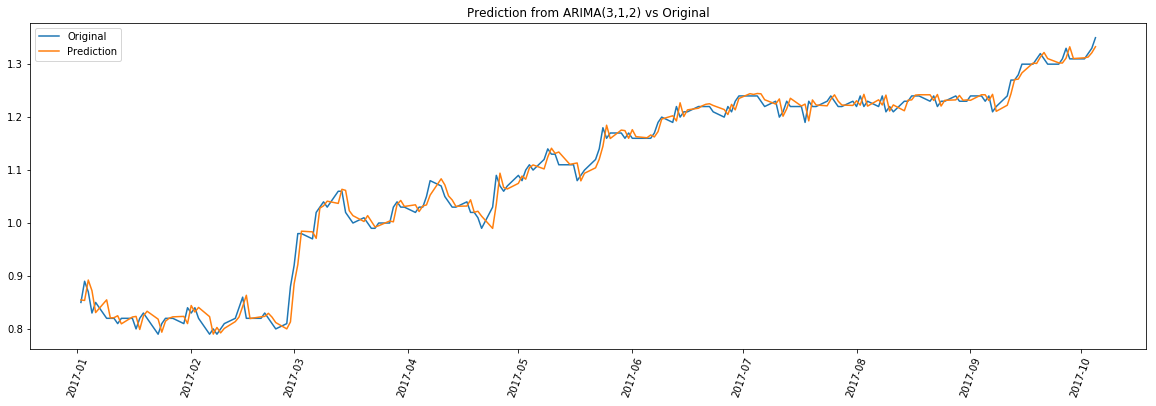

In [43]:
orig = plt.plot(test_one_year_actual,label='Original')
pred = plt.plot(pred_actual,label='Prediction')
plt.xticks(rotation=70)
plt.legend(loc='best')
plt.title('Prediction from ARIMA(3,1,2) vs Original')
print('RMSE: ', np.sqrt(mean_squared_error(test_one_year_actual, pred_actual)))
print('R sq: ',r2_score(test_one_year_actual,pred_actual))
plt.show()
plt.rcParams["figure.figsize"] = (20,6)

In [44]:
len(pred_actual)

199